# Inflation forecast for vegetable prices

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lag
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

In [2]:
spark = SparkSession.builder.appName("Forecasting").getOrCreate()
spark

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/13 20:18:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ramkrijal/agriculture-vegetables-fruits-time-series-prices")

print("Path to dataset files:", path)

/Users/venkateshshankar/miniconda3/envs/pyspark_env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /Users/venkateshshankar/.cache/kagglehub/datasets/ramkrijal/agriculture-vegetables-fruits-time-series-prices/versions/1


In [12]:
DF = spark.read.option("header","true").option("inferSchema","true").csv(path)

In [13]:
DF.show(5)

+---+-------------------+----------+----+-------+-------+-------+
| SN|          Commodity|      Date|Unit|Minimum|Maximum|Average|
+---+-------------------+----------+----+-------+-------+-------+
|  0| Tomato Big(Nepali)|2013-06-16|  Kg|   35.0|   40.0|   37.5|
|  1|Tomato Small(Local)|2013-06-16|  Kg|   26.0|   32.0|   29.0|
|  2|         Potato Red|2013-06-16|  Kg|   20.0|   21.0|   20.5|
|  3|       Potato White|2013-06-16|  Kg|   15.0|   16.0|   15.5|
|  4| Onion Dry (Indian)|2013-06-16|  Kg|   28.0|   30.0|   29.0|
+---+-------------------+----------+----+-------+-------+-------+
only showing top 5 rows



In [14]:
DF.select("Commodity").distinct().count()

132

In [15]:
import pyspark.sql.functions as F
groupedDF = DF.groupBy("Date").agg(F.sum("Average").alias("sum_average"))
groupedDF.show()

+----------+-----------+
|      Date|sum_average|
+----------+-----------+
|2013-09-09|     5475.5|
|2014-09-26|     6332.5|
|2014-11-12|     5450.5|
|2015-03-09|     5154.0|
|2015-05-19|     4976.5|
|2016-03-01|     5655.5|
|2013-09-19|     5285.5|
|2015-03-06|     5635.5|
|2016-04-25|     6710.0|
|2017-01-06|     5435.0|
|2014-08-01|     5260.0|
|2015-09-02|     5222.5|
|2015-12-22|     5995.5|
|2016-05-03|     6997.5|
|2016-07-26|     6394.0|
|2016-08-15|     7126.0|
|2016-08-31|     6864.0|
|2016-10-03|     6498.5|
|2014-06-03|     5817.0|
|2016-01-28|     5936.5|
+----------+-----------+
only showing top 20 rows



In [16]:
import pandas as pd
# Select date and value column (e.g., Average)
pdf = groupedDF.select("Date", "sum_average").dropna().toPandas()

# Make sure 'date' is datetime
pdf["Date"] = pd.to_datetime(pdf["Date"])

In [17]:
pdf.head()

,Date,sum_average
0,2013-09-09,5475.5
1,2014-09-26,6332.5
2,2014-11-12,5450.5
3,2015-03-09,5154.0
4,2015-05-19,4976.5


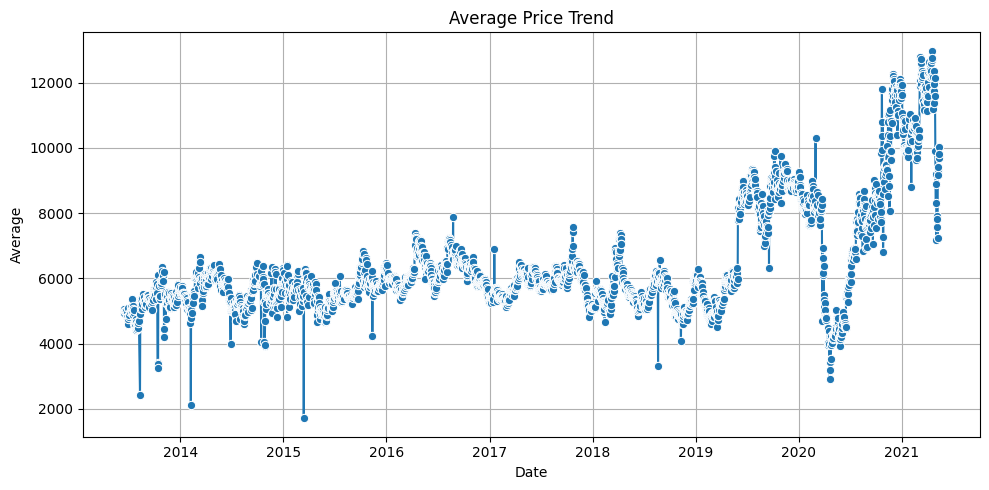

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.lineplot(data=pdf, x="Date", y="sum_average", marker="o")
plt.title("Average Price Trend")
plt.xlabel("Date")
plt.ylabel("Average")
plt.grid(True)
plt.tight_layout()
plt.show()

In [29]:
from pyspark.sql.window import Window

# Sort by date
df = groupedDF.orderBy("Date")

# Create lag features
window_spec = Window.orderBy("Date")
df = df.withColumn("lag_1", lag("sum_average", 1).over(window_spec))
df = df.withColumn("lag_2", lag("sum_average", 2).over(window_spec))

# Add time-based features
df = df.withColumn("day", F.dayofmonth("date")) \
       .withColumn("month", F.month("date")) \
       .withColumn("year", F.year("date"))

# Drop nulls from lagging
df = df.dropna()

In [30]:
from pyspark.ml.feature import VectorAssembler

feature_cols = ["lag_1", "lag_2", "day", "month", "year"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df = assembler.transform(df)

In [32]:
# 80% train, 20% test
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

In [33]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol="features", labelCol="sum_average")
model = lr.fit(train_df)

25/04/13 20:32:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/13 20:32:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/13 20:32:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/13 20:32:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/13 20:32:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/13 20:32:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/13 2

In [34]:
predictions = model.transform(test_df)
predictions.select("date", "sum_average", "prediction").show()

25/04/13 20:32:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/13 20:32:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/13 20:32:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/13 20:32:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/13 20:32:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/13 20:32:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/13 2

+----------+-----------+------------------+
|      date|sum_average|        prediction|
+----------+-----------+------------------+
|2013-06-20|     5013.0|  4971.28326421876|
|2013-06-27|     4823.0| 4951.008676087335|
|2013-06-30|     4592.5| 4818.820896554254|
|2013-07-05|     4870.0| 4832.466175887199|
|2013-07-15|     4925.0| 5076.891808438857|
|2013-07-19|     4881.0|5085.1778542325665|
|2013-07-26|     4606.0| 4689.224964912053|
|2013-08-02|     4607.0| 4462.400581022306|
|2013-08-16|     5357.5| 5137.447636336165|
|2013-08-18|     5398.0| 5291.342082964362|
|2013-08-19|     5052.0| 5370.319374121063|
|2013-08-23|     5523.5| 5165.030219916429|
|2013-08-26|     5417.5| 5372.406278310398|
|2013-09-01|     5168.5| 5251.921375539212|
|2013-09-09|     5475.5| 5419.033613076412|
|2013-09-17|     5351.0| 5289.866475848783|
|2013-09-27|     5558.0| 5231.229269986416|
|2013-10-24|     5785.5| 5432.039305247883|
|2013-11-07|     5422.5| 4310.433173724188|
|2013-11-13|     5256.0|5181.027

In [35]:
pdf = predictions.select("date", "sum_average", "prediction").toPandas()
pdf["date"] = pd.to_datetime(pdf["date"])

25/04/13 20:32:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/13 20:32:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/13 20:32:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/13 20:32:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/13 20:32:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/13 20:32:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/13 2

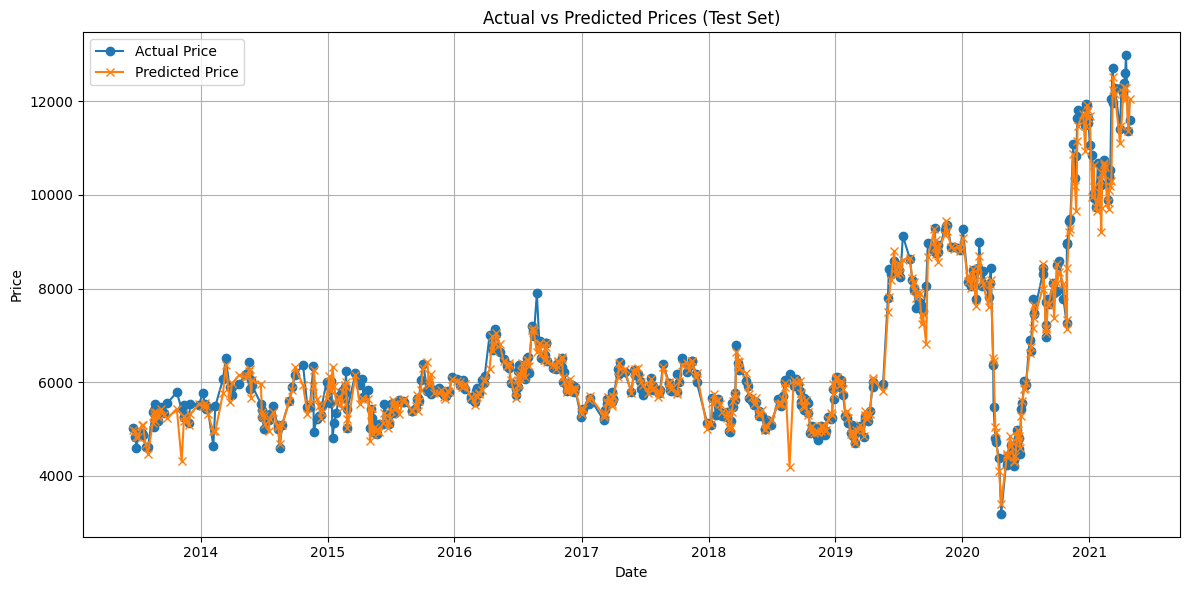

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(pdf["date"], pdf["sum_average"], label="Actual Price", marker="o")
plt.plot(pdf["date"], pdf["prediction"], label="Predicted Price", marker="x")

plt.title("Actual vs Predicted Prices (Test Set)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [39]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol="sum_average", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"RMSE on test data: {rmse:.2f}")

25/04/13 20:35:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/13 20:35:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/13 20:35:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/13 20:35:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/13 20:35:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


RMSE on test data: 296.11


25/04/13 20:35:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/13 20:35:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/13 20:35:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/13 20:35:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
